# Set up

## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import t
import scipy.optimize as opt
import os
import glob
import pandas as pd
import arviz as az
import pymc3 as pm
from datetime import datetime, timedelta
from scipy.special import expit as logistic
import pingouin as pg
import warnings
warnings.filterwarnings("ignore")

## Set up plotting

In [3]:
#Plotting
import seaborn as sns
plt.rcParams.update({'font.size': 20})
color_t1 = '#ca0020'
color_t2 = '#0571b0'

color_a = '#7b3294'
color_b = '#008837'

# color_a = '#d01c8b'
# color_b = '#4dac26'

#Set figure path and extension
fig_path = '/Users/jonathanwood/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofDelaware-o365/Team-CHS-PT-Morton Lab - Split-Belt Recal - Jonathan - Split-Belt Recal - Jonathan/Docs/Writing/Figures'

extension = '.eps'

## Define functions

In [6]:
def UniqueVals(stims, responses):
    
    """
    Definition: Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [10]:
def calc_CCC(D1,D2):
    
    """
    Defintion: This function calculate the correspondance correlation coefficient for two sets of data 
    
    Inputs:
    data = dataset with 2 columns, test 1 and test 2
    
    Outputs:
    CCC = correspondence correlation coefficient
    """
    
    mu1 = np.mean(D1)
    mu2 = np.mean(D2)
    var1 = np.sum((D1-mu1)**2) / (len(D1))
    var2 = np.sum((D2-mu2)**2) / (len(D2))
    cov = np.sum((D1 - mu1)*(D2-mu2)) / (len(D1))

    #calculate the CCC
    CCC = (2*cov) / (var1+var2 + (mu1-mu2)**2)
    
    #Calculate the variance of the CCC
    1/(len(D1)-2)

    return CCC

In [52]:
def ccc_boot(D1, D2, nboots):
    
    if len(D1) != len(D2):
        raise ValueError('Lengths of D1 and D2 must be the same')
        
    boot_ccc = [] 
    n = len(D1)
    for b in range(nboots):
        boot_idx = np.random.choice(np.arange(n),size=n,replace=True)
        boot_ccc.append(calc_CCC(D1[boot_idx],D2[boot_idx]))

    #Calculate 95% CI
    sorted_array = np.sort(boot_ccc)

    idx_low = round(nboots*0.025)
    idx_hi = round(nboots*0.975)
    
    ci95 = [sorted_array[idx_low], sorted_array[idx_hi]]
    
    #Calculate exact p-value
    p_val = sum(np.array(boot_ccc)<=0)/len(boot_ccc)

    return boot_ccc, ci95, p_val

## Load data

In [7]:
# #Change the directory (work computer)
# os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')
#Change the directory (Jonathans Mac)
os.chdir('/Users/jonathanwood/Documents/GitHub/Split-Belt-AFC-Reliability/Data/TestRetest_PSI')

#Load the data and combine
file_names = glob.glob("*.csv")
combined_data = [pd.read_csv(i, parse_dates=['StartTime']) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for easy indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

N = len(np.unique(DF.SID))
#Print the subjects
print('Included subjects =', np.unique(DF.SID))
print('N =', N)

Included subjects = ['TRTPSI_01' 'TRTPSI_02' 'TRTPSI_07' 'TRTPSI_08' 'TRTPSI_10' 'TRTPSI_11'
 'TRTPSI_12' 'TRTPSI_13' 'TRTPSI_14' 'TRTPSI_15' 'TRTPSI_16' 'TRTPSI_17'
 'TRTPSI_18']
N = 13


# Plots

## Individual data

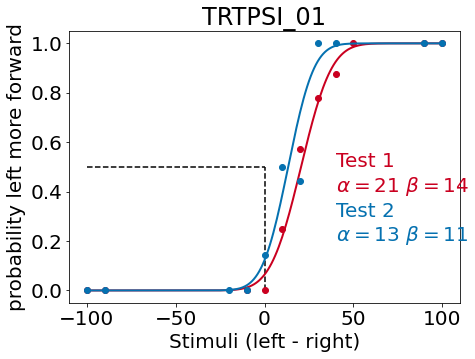

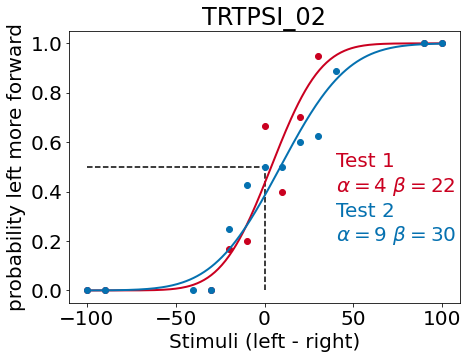

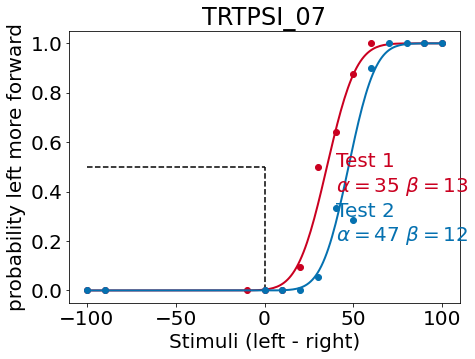

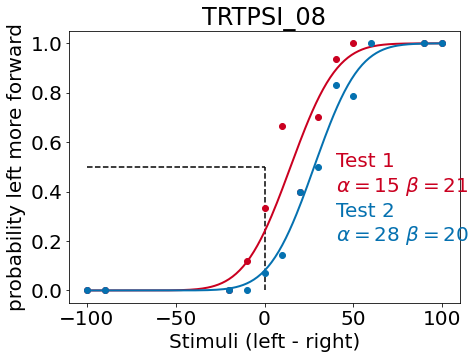

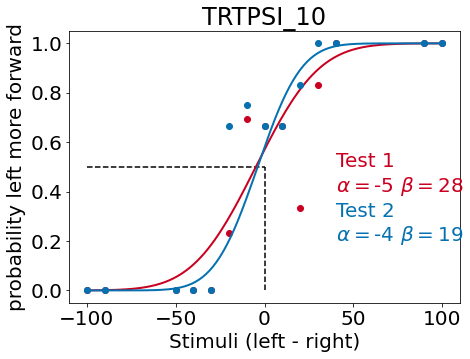

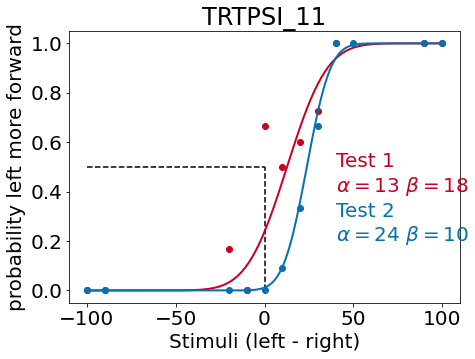

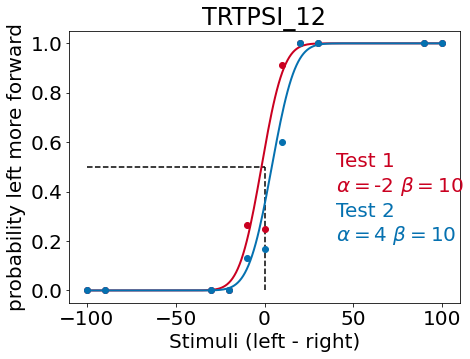

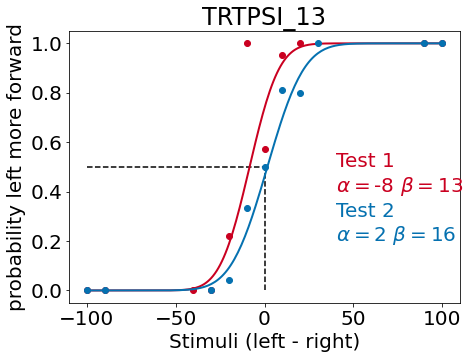

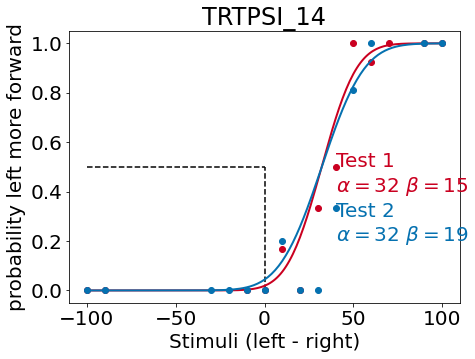

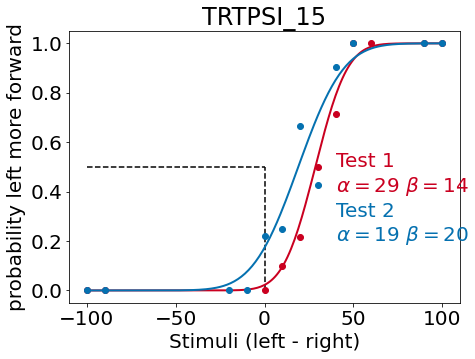

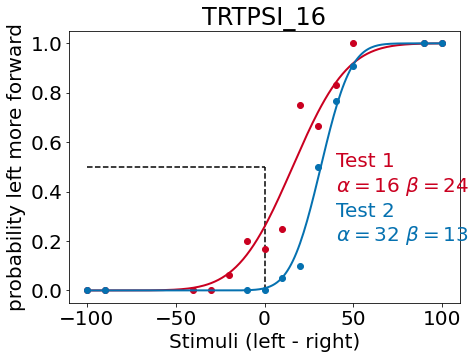

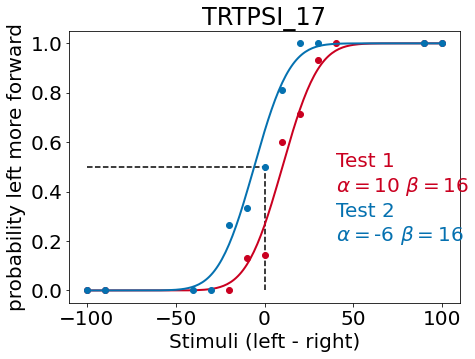

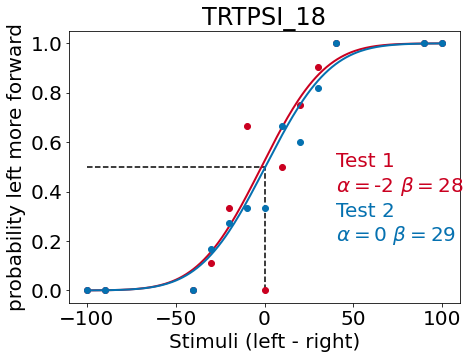

In [8]:
x = np.arange(-100,101)
#Loop through all subejcts
for name, test in grp_subjs:
    
    #Index the different tests
    Test_a = test[test.Test=='a']
    Test_b = test[test.Test=='b']
    
    #Index baseline difference
    BslDiff_1 = round(Test_a.BslDiff.values[0])
    BslDiff_2 = round(Test_b.BslDiff.values[0])

    #Calculate psychometric function for the PSI algorithm
    psi_a = norm.cdf(x,Test_a.Alpha_EV.values[-1]+BslDiff_1,Test_a.Beta_EV.values[-1])
    psi_b = norm.cdf(x,Test_b.Alpha_EV.values[-1]+BslDiff_2,Test_b.Beta_EV.values[-1])
    
    #Index the actual stimulus values
    x_1, Nstims_1, Kleft_1 = UniqueVals(Test_a.AllStims.values+BslDiff_1, Test_a.BinaryResponses.values)
    x_2, Nstims_2, Kleft_2 = UniqueVals(Test_b.AllStims.values+BslDiff_2, Test_b.BinaryResponses.values)

    #Plot
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(np.arange(-100,1),np.ones(101)*0.5,'k--')
    ax.plot(np.zeros(50),np.linspace(0,0.5),'k--')
    
    #Test 1
    ax.plot(x, psi_a, c=color_t1, lw=2)
    ax.plot(x_1, Kleft_1/Nstims_1, 'o', c=color_t1)
    ax.text(40,0.5,'Test 1', c=color_t1)
    ax.text(40, 0.4, r'$\alpha=$' + str(round(Test_a.Alpha_EV.values[-1]+BslDiff_1))
            + r' $\beta=$' + str(round(Test_a.Beta_EV.values[-1])), c=color_t1)
 
    #Test 2
    ax.plot(x, psi_b, c=color_t2, lw=2)
    ax.plot(x_2, Kleft_2/Nstims_2, 'o', c=color_t2)
    ax.text(40,0.3,'Test 2', c=color_t2)
    ax.text(40,0.2, r'$\alpha=$' + str(round(Test_b.Alpha_EV.values[-1]+BslDiff_2))
           + r' $\beta=$' + str(round(Test_b.Beta_EV.values[-1])), c=color_t2)
   
    ax.set(ylabel='probability left more forward', xlabel='Stimuli (left - right)', title=name)
    fig.savefig(fig_path + '/' + name + extension, transparent=True, bbox_inches=None, pad_inches=0.1, edgecolor='w', dpi=1600)
    

## Test 1 and 2 comparison

Alpha persons
(0.8107526998374217, 0.0007731367517494997)
Beta persons
(0.5986244274537076, 0.030651182509455206)


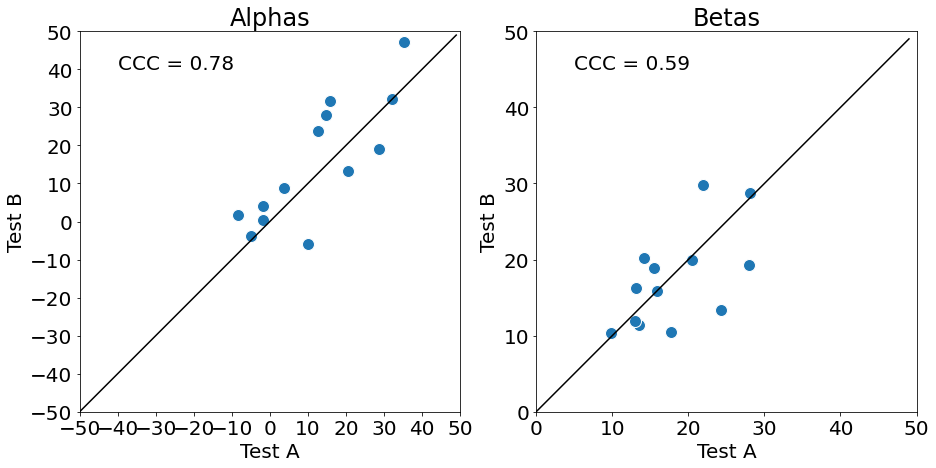

In [11]:
unique_tests = ['a','b']
alphas, betas = np.empty((len(grp_subjs),2)), np.empty((len(grp_subjs),2))
#Extract the final estimates of the alpha and beta values
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        # print(name, test_id)
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        alphas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Alpha_EV.values[-1]+BslDiff
        betas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Beta_EV.values[-1]
        
alpha_ccc = calc_CCC(alphas[:,0],alphas[:,1])
beta_ccc = calc_CCC(betas[:,0],betas[:,1])

print('Alpha persons')
print(scipy.stats.pearsonr(alphas[:,0],alphas[:,1]))
print('Beta persons')
print(scipy.stats.pearsonr(betas[:,0],betas[:,1]))

#Plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(alphas[:,0], alphas[:,1], 'o', ms=12, mec='w')
ax[0].plot(np.arange(-50,50), np.arange(-50,50),'k')
ax[0].text(-40, 40, 'CCC = ' + str(round(alpha_ccc,2)))
ax[0].set(xlim=(-50,50), ylim=(-50,50), xticks=np.arange(-50,60,10), yticks=np.arange(-50,60,10), title='Alphas', xlabel='Test A', ylabel='Test B')
ax[1].plot(betas[:,0], betas[:,1],'o', ms=12, mec='w')
ax[1].plot(np.arange(0,50), np.arange(0,50),'k')
ax[1].text(5, 45, 'CCC = ' + str(round(beta_ccc,2)))
ax[1].set(xlim=(0,50), ylim=(0,50), title='Betas', xlabel='Test A', ylabel='Test B')
plt.savefig(fig_path + '/CCCplt' + extension, transparent=False, bbox_inches=None, pad_inches=0.1, edgecolor='w', dpi=1600)

# Stats

## Descriptives

In [12]:
#Alphas
print('All Alphas = ' + str(round(np.mean(alphas))) + '+/-' + str(round(np.std(alphas))))
print('Test A Alphas = ' + str(round(np.mean(alphas[:,0]))) + '+/-' + str(round(np.std(alphas[:,0]))))
print('Test B Alphas = ' + str(round(np.mean(alphas[:,1]))) + '+/-' + str(round(np.std(alphas[:,1]))))

All Alphas = 14+/-15
Test A Alphas = 12+/-14
Test B Alphas = 15+/-16


In [13]:
#Betas
print('All Betas = ' + str(round(np.mean(betas))) + '+/-' + str(round(np.std(betas))))
print('Test A Betas = ' + str(round(np.mean(betas[:,0]))) + '+/-' + str(round(np.std(betas[:,0]))))
print('Test B Betas = ' + str(round(np.mean(betas[:,1]))) + '+/-' + str(round(np.std(betas[:,1]))))

All Betas = 18+/-6
Test A Betas = 18+/-6
Test B Betas = 17+/-6


In [102]:
#Differences
alpha_diff = alphas[:,0] - alphas[:,1]
beta_diff = betas[:,0] - betas[:,1]

print('Mean alpha diff = ' + str(round(np.mean(alpha_diff))) + '+/-' + str(round(np.std(alpha_diff))))
print('Mean beta diff = ' + str(round(np.mean(beta_diff))) + '+/-' + str(round(np.std(beta_diff))))

Mean alpha diff = -3+/-9
Mean beta diff = 1+/-5


## Normality 

In [19]:
pg.normality(alphas[:,0])

,W,pval,normal
0,0.949017,0.583472,True


In [21]:
pg.normality(alphas[:,1])

,W,pval,normal
0,0.947767,0.564874,True


In [16]:
pg.normality(betas[:,0])

,W,pval,normal
0,0.917488,0.231967,True


In [17]:
pg.normality(betas[:,1])

,W,pval,normal
0,0.889648,0.096473,True


In [27]:
pg.normality(alpha_diff)

,W,pval,normal
0,0.940251,0.460158,True


In [28]:
pg.normality(beta_diff)

,W,pval,normal
0,0.949807,0.595374,True


## Pearson correlation

In [39]:
alpha_pearsons = scipy.stats.pearsonr(alphas[:,0],alphas[:,1])
beta_pearsons = scipy.stats.pearsonr(betas[:,0],betas[:,1])
print('Alpha persons r = ' + str(round(alpha_pearsons[0],2)) + ', p = ' + str(round(alpha_pearsons[1],4)))
print('Beta persons r = ' + str(round(beta_pearsons[0],2)) + ', p = ' + str(round(beta_pearsons[1],4)))

Alpha persons r = 0.81, p = 0.0008
Beta persons r = 0.6, p = 0.0307


## CCC

In [55]:
alpha_ccc = calc_CCC(alphas[:,0],alphas[:,1])
beta_ccc = calc_CCC(betas[:,0],betas[:,1])

nboots = 10000
boot_alpha, ci95_alpha, p_alpha = ccc_boot(alphas[:,0],alphas[:,1], nboots)
boot_beta, ci95_beta, p_beta = ccc_boot(betas[:,0],betas[:,1], nboots)

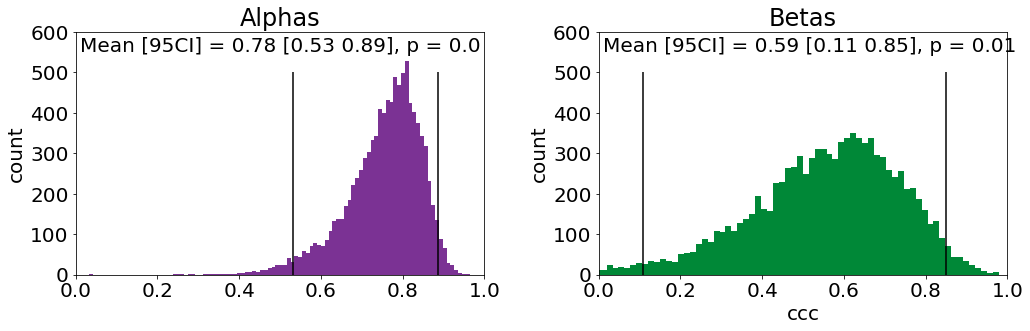

In [74]:
#Histograms
fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
ax[0].hist(boot_alpha, bins=100, color=color_a)
ax[0].vlines(x=ci95_alpha, ymin=0, ymax=500, color='k')
ax[0].text(0.01, 550, 'Mean [95CI] = ' + str(np.round(alpha_ccc,2)) + 
           ' ' + str(np.round(ci95_alpha,2)) + ', p = ' + str(round(p_alpha,3)))
ax[0].set(xlim=(0,1), ylim=(0,600), title='Alphas',ylabel='count')

ax[1].hist(boot_beta, bins=100, color=color_b)
ax[1].vlines(x=ci95_beta, ymin=0, ymax=500, color='k')
ax[1].text(0.01, 550, 'Mean [95CI] = ' + str(np.round(beta_ccc,2)) + 
           ' ' + str(np.round(ci95_beta,2)) + ', p = ' + str(round(p_beta,3)))
ax[1].set(xlim=(0,1), ylim=(0,600),  title='Betas', xlabel='ccc',ylabel='count')
plt.show()

## Bland-altman agreement 

### Test for a bias (mean difference from 0)

In [103]:
alpha_bias = stats.ttest_1samp(alpha_diff,0)
beta_bias = stats.ttest_1samp(beta_diff,0)

print('Mean alpha diff = ' + str(round(np.mean(alpha_diff))) + '+/-' + str(round(np.std(alpha_diff)))
     + ' (t=' + str(round(alpha_bias.statistic,2)) + ', p=' + str(round(alpha_bias.pvalue,2)) + ')')

print('Mean beta diff = ' + str(round(np.mean(beta_diff))) + '+/-' + str(round(np.std(beta_diff)))
     + ' (t=' + str(round(beta_bias.statistic,2)) + ', p=' + str(round(beta_bias.pvalue,2)) + ')')


Mean alpha diff = -3+/-9 (t=-1.26, p=0.23)
Mean beta diff = 1+/-5 (t=0.47, p=0.65)


### Regression of 'true' values and difference values

In [104]:
mean_a = np.mean(alphas,axis=1)
mean_b = np.mean(betas,axis=1)

alpha_reg = stats.linregress(mean_a,alpha_diff)
beta_reg = stats.linregress(mean_b,beta_diff)

diff_hat_a = alpha_reg.slope*mean_a + alpha_reg.intercept
diff_hat_b = beta_reg.slope*mean_b + beta_reg.intercept

print('Alpha bias slope = ' + str(round(alpha_reg.slope,2)) + '+/-' + str(round(alpha_reg.stderr,2)) + ', p = ' + 
      str(round(alpha_reg.pvalue,2)))
print('Beta bias slope = ' + str(round(beta_reg.slope,2)) + '+/-' + str(round(beta_reg.stderr,2)) + ', p = ' + 
      str(round(beta_reg.pvalue,2)))

Alpha bias slope = -0.15+/-0.19, p = 0.46
Beta bias slope = -0.09+/-0.3, p = 0.78


### Plot

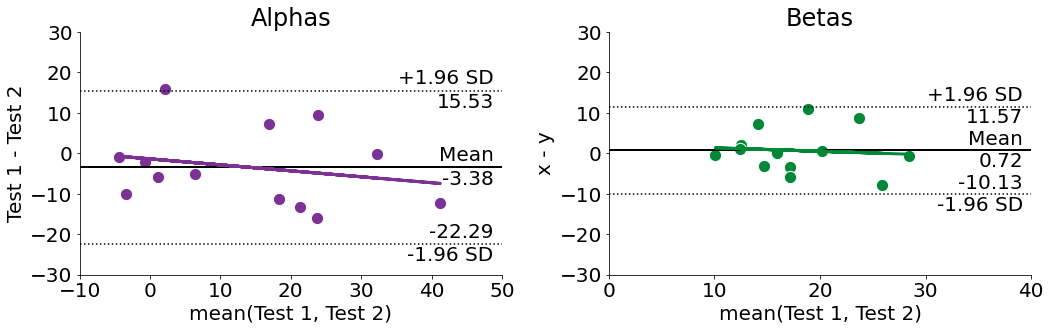

In [105]:
#Bland-altman
fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True) 
pg.plot_blandaltman(alphas[:,0], alphas[:,1],ax=ax[0],confidence=None, scatter_kws={'color':color_a, 'edgecolors':'w', 's':150})
ax[0].plot(mean_a, diff_hat_a, c=color_a, lw=3)
ax[0].set(title='Alphas', xlabel='mean(Test 1, Test 2)', ylabel='Test 1 - Test 2',ylim=(-30,30),xlim=(-10,50))

pg.plot_blandaltman(betas[:,0], betas[:,1],ax=ax[1],confidence=None, scatter_kws={'color':color_b, 'edgecolors':'w', 's':150})
ax[1].plot(mean_b, diff_hat_b, c=color_b, lw=3)
ax[1].set(xlabel='mean(Test 1, Test 2)', title='Betas', ylim=(-30,30),xlim=(0,40))
plt.show()

## Validity - logistic regression

In [176]:
#Orgainze the data
x_stims, y, x_move_dir = np.empty((len(DF),1)), np.empty((len(DF),1)), np.empty((len(DF),1))
for i in range(len(DF)):
    x_stims[i,0] = DF.AllStims.values[i] + round(DF.BslDiff.values[i])
    x_move_dir[i,0] = DF.AllStarts.values[i] > DF.AllStims.values[i]
    
x_SID = [np.ones((150,1), dtype=int)*int(i) for i in range(len(np.unique(DF.SID)))]
x_SID = np.concatenate(x_SID)
y = DF.BinaryResponses.values


In [169]:
X = np.concatenate((x_SID,x_stims,x_move_dir),axis=1)

In [179]:
pg.logistic_regression(X,y)

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-1.036594,0.134702,-7.695476,1.409689e-14,-1.300604,-0.772583
1,x1,0.000054,0.015831,0.003400,9.972873e-01,-0.030974,0.031082
2,x2,0.063883,0.002976,21.466867,3.177274e-102,0.058050,0.069715
3,x3,0.164130,0.118763,1.381989,1.669752e-01,-0.068642,0.396901
